In [1]:
## Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score,classification_report,confusion_matrix,make_scorer
from xgboost import XGBClassifier

In [3]:
# Importing the train dataset
train_df = pd.read_csv("train_users_2.csv",header = 0,parse_dates=["date_account_created","date_first_booking","timestamp_first_active"])

In [4]:
# Importing the test dataset
test_df = pd.read_csv("test_users.csv",header = 0,parse_dates=["date_account_created","date_first_booking","timestamp_first_active"])

In [5]:
# Joining the two datasets row wise
data_all = pd.concat((train_df, test_df), axis = 0, ignore_index = True)

In [6]:
data_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
test_df["id"].nunique()

62096

In [8]:
pd.DataFrame(data_all).isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
dtype: int64

In [9]:
data_all.describe()

,age,signup_flow
count,158681.000000,275547.000000
mean,47.145310,4.291965
std,142.629468,8.794313
min,1.000000,0.000000
25%,28.000000,0.000000
50%,33.000000,0.000000
75%,42.000000,1.000000
max,2014.000000,25.000000


#The age does not seem to be right with min age of 1 and max age of 2014. Getting the count of people with age > 150

In [10]:
data_all.loc[data_all['age']>150]['age'].describe()

count     828.000000
mean     2007.117150
std        22.219408
min      1920.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [11]:
data_all.loc[data_all['age']<18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [12]:
# Asuming age is between 15 and 100
data_all.loc[data_all.age > 100, 'age'] = np.nan
data_all.loc[data_all.age < 15, 'age'] = np.nan

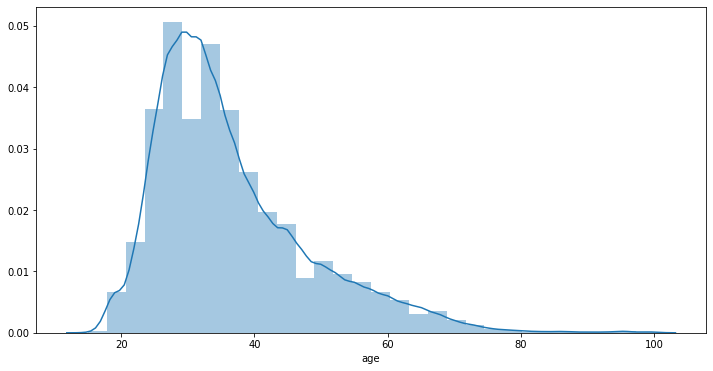

In [13]:
# Histogram of the age
train_df.loc[train_df.age > 100, 'age'] = np.nan
train_df.loc[train_df.age < 15, 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.distplot(train_df["age"],bins=30)

In [14]:
data_all["gender"].unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

In [15]:
data_all["first_browser"].unique()

array(['Chrome', 'IE', 'Firefox', 'Safari', '-unknown-', 'Mobile Safari',
       'Chrome Mobile', 'RockMelt', 'Chromium', 'Android Browser',
       'AOL Explorer', 'Palm Pre web browser', 'Mobile Firefox', 'Opera',
       'TenFourFox', 'IE Mobile', 'Apple Mail', 'Silk', 'Camino', 'Arora',
       'BlackBerry Browser', 'SeaMonkey', 'Iron', 'Sogou Explorer',
       'IceWeasel', 'Opera Mini', 'SiteKiosk', 'Maxthon',
       'Kindle Browser', 'CoolNovo', 'Conkeror', 'wOSBrowser',
       'Google Earth', 'Crazy Browser', 'Mozilla', 'OmniWeb',
       'PS Vita browser', 'NetNewsWire', 'CometBird', 'Comodo Dragon',
       'Flock', 'Pale Moon', 'Avant Browser', 'Opera Mobile',
       'Yandex.Browser', 'TheWorld Browser', 'SlimBrowser', 'Epic',
       'Stainless', 'Googlebot', 'Outlook 2007', 'IceDragon', 'IBrowse',
       'Nintendo Browser', 'UC Browser'], dtype=object)

In [16]:
data_all.gender.replace('-unknown-', np.nan, inplace=True)
data_all.first_browser.replace('-unknown-', np.nan, inplace=True)

Text(0.5, 1.0, 'Gender Distribution')

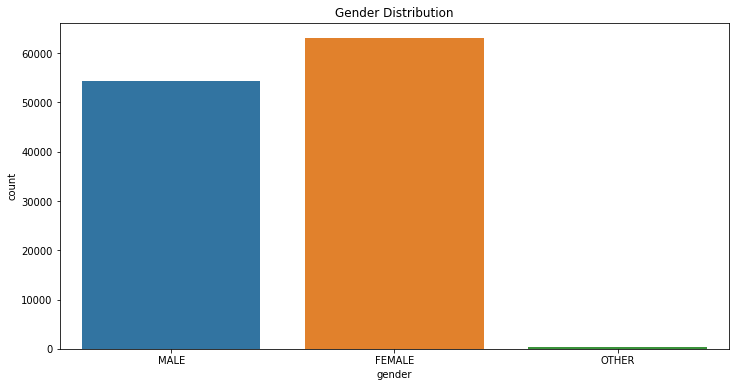

In [17]:
# Plotting the number of people in each gender
train_df.gender.replace('-unknown-', np.nan, inplace=True)
train_df.first_browser.replace('-unknown-', np.nan, inplace=True)
plt.figure(figsize=(12,6))
sns.countplot(x="gender",data = train_df)
plt.title("Gender Distribution")

Text(0.5, 1.0, 'Gender Distribution')

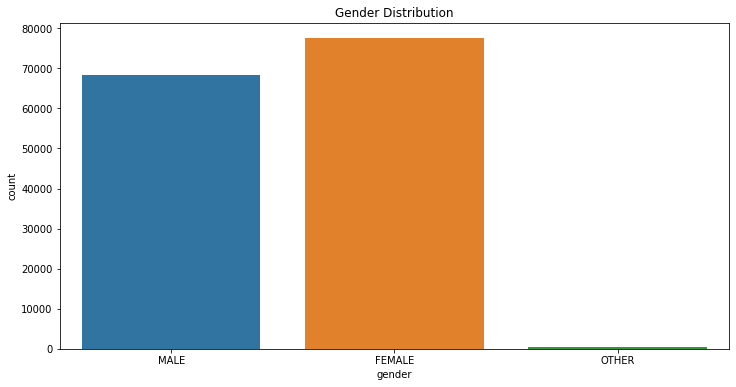

In [18]:
# Plotting the number of people in each gender
data_all.gender.replace('-unknown-', np.nan, inplace=True)
data_all.first_browser.replace('-unknown-', np.nan, inplace=True)
plt.figure(figsize=(12,6))
sns.countplot(x="gender",data = data_all)
plt.title("Gender Distribution")

In [19]:
data_all["gender"].value_counts()

FEMALE    77524
MALE      68209
OTHER       334
Name: gender, dtype: int64

In [20]:
train_df["gender"].value_counts()

FEMALE    63041
MALE      54440
OTHER       282
Name: gender, dtype: int64

Text(0.5, 1.0, 'Destination Countries')

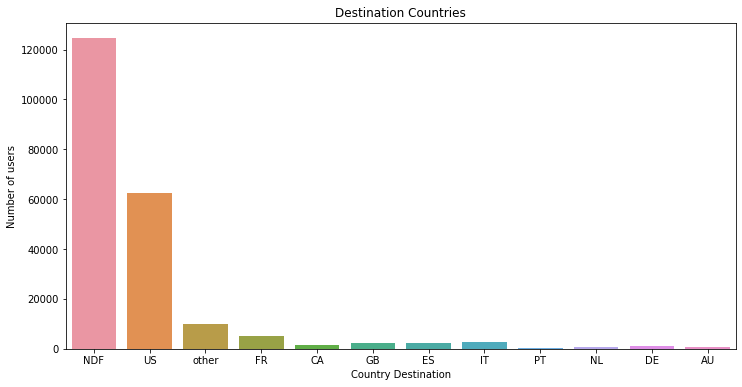

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x="country_destination",data=data_all)
plt.xlabel("Country Destination")
plt.ylabel("Number of users")
plt.title("Destination Countries")

In [22]:
# From the above chart we can see that most of the time, there was'nt any booking. Looking at the numbers
train_df["country_destination"].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

Text(0.5, 1.0, 'Destination Countries for users who have made bookings')

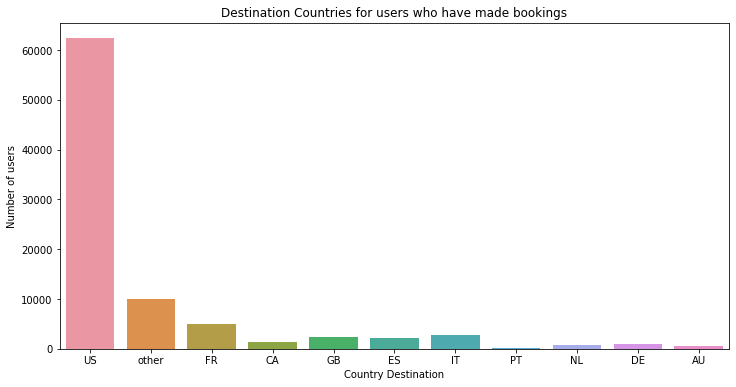

In [23]:
# How about the the people who have made booking. So creating a dataframe without NDF and plotting their favourite destinations
data_all_without_NDF = data_all[data_all['country_destination']!='NDF']
plt.figure(figsize=(12,6))
sns.countplot(x="country_destination",data=data_all_without_NDF)
plt.xlabel("Country Destination")
plt.ylabel("Number of users")
plt.title("Destination Countries for users who have made bookings")


Text(0.5, 1.0, 'Sign-up Method Distribution')

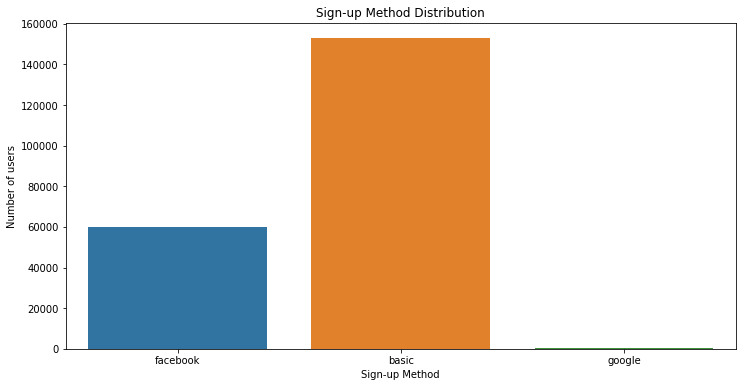

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x="signup_method",data=train_df)
plt.xlabel("Sign-up Method")
plt.ylabel("Number of users")
plt.title("Sign-up Method Distribution")

In [25]:
print(data_all["signup_method"].value_counts())
print("\n")
print(train_df["signup_method"].value_counts())

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64


basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64


In [26]:
df_without_NDF = train_df[train_df["country_destination"]!="NDF"]

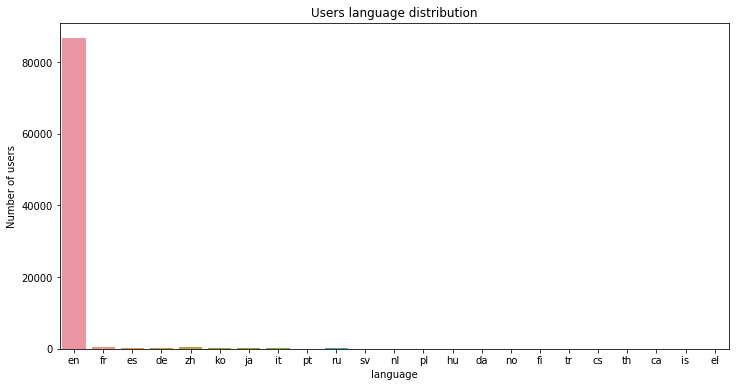

In [27]:
plt.figure(figsize=(12,6))
sns.countplot(x='language', data=df_without_NDF)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution')
plt.show()

In [28]:
df_without_NDF["language"].value_counts()

en    86664
zh      521
fr      399
es      275
de      270
ko      241
ru      110
it      104
ja       84
pt       62
sv       44
nl       35
tr       20
da       19
no       13
pl       13
cs        9
fi        7
el        6
hu        4
th        4
is        2
ca        2
Name: language, dtype: int64

Text(0.5, 1.0, 'Signup app distribution')

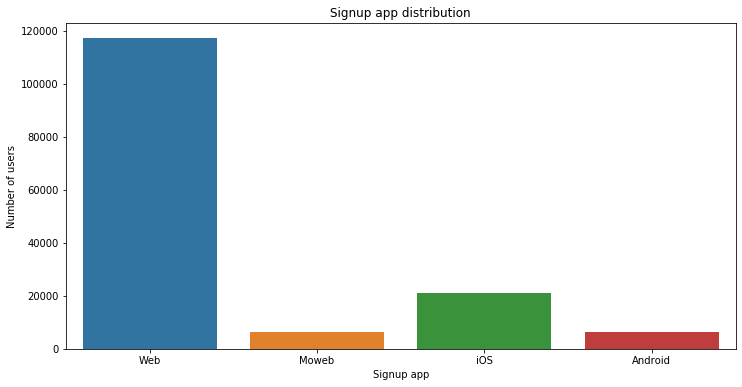

In [29]:
# App used by users who have made bookings
plt.figure(figsize=(12,6))
sns.countplot(x='signup_app', data=data_all_without_NDF)
plt.xlabel('Signup app')
plt.ylabel('Number of users')
plt.title('Signup app distribution')

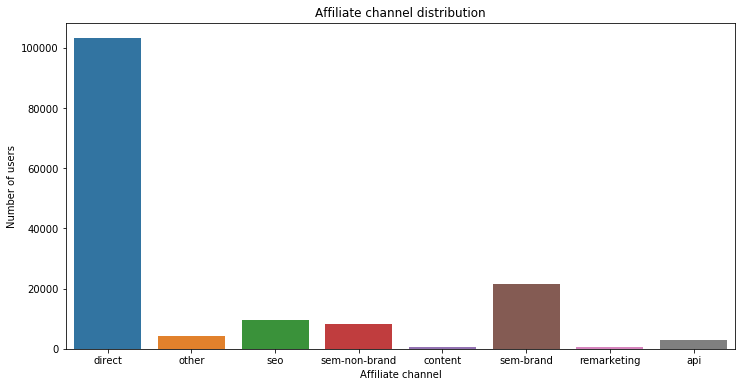

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(x='affiliate_channel', data=data_all_without_NDF)
plt.xlabel('Affiliate channel')
plt.ylabel('Number of users')
plt.title('Affiliate channel distribution')
plt.show()

In [31]:
data_all_without_NDF["affiliate_channel"].value_counts()

direct           103242
sem-brand         21488
seo                9654
sem-non-brand      8381
other              4186
api                2785
content             728
remarketing         540
Name: affiliate_channel, dtype: int64

# Predictive Modeling

In [35]:
#Loading the train and test data again
train_df = pd.read_csv("train_users_2.csv",header = 0,parse_dates=["date_account_created","date_first_booking","timestamp_first_active"])
test_df = pd.read_csv("test_users.csv",header = 0,parse_dates=["date_account_created","date_first_booking","timestamp_first_active"])

In [36]:
labels = train_df['country_destination'].values
train_df.drop(['country_destination'], axis=1,inplace=True)
test_id = test_df['id']
train_rows = train_df.shape[0]

In [37]:
data_all = pd.concat((train_df, test_df), axis = 0, ignore_index = True)

# Feature Engineering

In [38]:
# 1. Dropping the data_first_booking column as it is blank in the test set
data_all.drop(["date_first_booking"],axis=1,inplace=True)

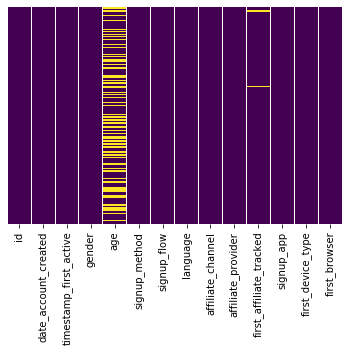

In [39]:
sns.heatmap(data_all.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [40]:
# Splitting date time data for time first active into weekday, year,month and day
#data_all['timestamp_first_active'] = pd.to_datetime((data_all.timestamp_first_active), format='%Y%m%d')
data_all['weekday_first_active'] = data_all.timestamp_first_active.dt.strftime('%A')
data_all['tfa_year'] = data_all.timestamp_first_active.dt.year
data_all['tfa_month'] = data_all.timestamp_first_active.dt.month
data_all['tfa_day'] = data_all.timestamp_first_active.dt.day

In [41]:
# Splitting date time data for date account created into weekday, year,month and day
#data_all['timestamp_first_active'] = pd.to_datetime((data_all.timestamp_first_active), format='%Y%m%d')
data_all['weekday_account_created'] = data_all.date_account_created.dt.strftime('%A')
data_all['dac_year'] = data_all.date_account_created.dt.year
data_all['dac_month'] = data_all.date_account_created.dt.month
data_all['dac_day'] = data_all.date_account_created.dt.day


In [42]:
data_all.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,first_device_type,first_browser,weekday_first_active,tfa_year,tfa_month,tfa_day,weekday_account_created,dac_year,dac_month,dac_day
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,...,Mac Desktop,Chrome,Thursday,2009,3,19,Monday,2010,6,28
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,...,Mac Desktop,Chrome,Saturday,2009,5,23,Wednesday,2011,5,25
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,...,Windows Desktop,IE,Tuesday,2009,6,9,Tuesday,2010,9,28
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,...,Mac Desktop,Firefox,Saturday,2009,10,31,Monday,2011,12,5
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,...,Mac Desktop,Chrome,Tuesday,2009,12,8,Tuesday,2010,9,14


In [11]:
#Creating a column for the time lag between account created and account active
from datetime import timedelta
time_lag = (data_all['date_account_created'] - data_all['timestamp_first_active'])
data_all["time_lag_in_days"] = time_lag / timedelta(days=1)

In [12]:
data_all.drop(["date_account_created","timestamp_first_active"],axis=1,inplace=True)

In [13]:
data_all.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,first_browser,weekday_first_active,tfa_year,tfa_month,tfa_day,weekday_account_created,dac_year,dac_month,dac_day,time_lag_in_days
0,gxn3p5htnn,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,...,Chrome,Thursday,2009,3,19,Monday,2010,6,28,465.810475
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,Chrome,Saturday,2009,5,23,Wednesday,2011,5,25,731.258229
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,IE,Tuesday,2009,6,9,Tuesday,2010,9,28,475.032789
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,Firefox,Saturday,2009,10,31,Monday,2011,12,5,764.748970
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,...,Chrome,Tuesday,2009,12,8,Tuesday,2010,9,14,279.742303


In [15]:
# Asuming age is between 15 and 100
data_all.loc[data_all.age > 100, 'age'] = np.nan
data_all.loc[data_all.age < 18, 'age'] = np.nan

In [16]:
data_all["first_affiliate_tracked"].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

In [17]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   gender                   275547 non-null  object 
 2   age                      155803 non-null  float64
 3   signup_method            275547 non-null  object 
 4   signup_flow              275547 non-null  int64  
 5   language                 275547 non-null  object 
 6   affiliate_channel        275547 non-null  object 
 7   affiliate_provider       275547 non-null  object 
 8   first_affiliate_tracked  269462 non-null  object 
 9   signup_app               275547 non-null  object 
 10  first_device_type        275547 non-null  object 
 11  first_browser            275547 non-null  object 
 12  weekday_first_active     275547 non-null  object 
 13  tfa_year                 275547 non-null  int64  
 14  tfa_

In [18]:
#Dropping the id column
data_all.drop(["id"],axis=1,inplace=True)

In [19]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow',
    'first_affiliate_tracked'
]

for categorical_feature in categorical_features:
    data_all[categorical_feature] = data_all[categorical_feature].astype('category')

In [20]:
categorical_features = [
    'weekday_first_active',
    'weekday_account_created'
]

for categorical_feature in categorical_features:
    data_all[categorical_feature] = data_all[categorical_feature].astype('category')

In [21]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   gender                   275547 non-null  category
 1   age                      155803 non-null  float64 
 2   signup_method            275547 non-null  category
 3   signup_flow              275547 non-null  category
 4   language                 275547 non-null  category
 5   affiliate_channel        275547 non-null  category
 6   affiliate_provider       275547 non-null  category
 7   first_affiliate_tracked  269462 non-null  category
 8   signup_app               275547 non-null  category
 9   first_device_type        275547 non-null  category
 10  first_browser            275547 non-null  category
 11  weekday_first_active     275547 non-null  category
 12  tfa_year                 275547 non-null  int64   
 13  tfa_month                275547 non-null  in

In [22]:
# One hot encoding. Changing all categorical variables to dummy variables
data_all = pd.get_dummies(data_all, columns = data_all.select_dtypes(exclude=['int64','float64','object']).columns, drop_first = True)

In [23]:
data_all.head()

,age,tfa_year,tfa_month,tfa_day,dac_year,dac_month,dac_day,time_lag_in_days,gender_FEMALE,gender_MALE,...,weekday_first_active_Sunday,weekday_first_active_Thursday,weekday_first_active_Tuesday,weekday_first_active_Wednesday,weekday_account_created_Monday,weekday_account_created_Saturday,weekday_account_created_Sunday,weekday_account_created_Thursday,weekday_account_created_Tuesday,weekday_account_created_Wednesday
0,NaN,2009,3,19,2010,6,28,465.810475,0,0,...,0,1,0,0,1,0,0,0,0,0
1,38.0,2009,5,23,2011,5,25,731.258229,0,1,...,0,0,0,0,0,0,0,0,0,1
2,56.0,2009,6,9,2010,9,28,475.032789,1,0,...,0,0,1,0,0,0,0,0,1,0
3,42.0,2009,10,31,2011,12,5,764.748970,1,0,...,0,0,0,0,1,0,0,0,0,0
4,41.0,2009,12,8,2010,9,14,279.742303,0,0,...,0,0,1,0,0,0,0,0,1,0


In [24]:
#Splitting train and prediction
vals = data_all.values
X_train = vals[:train_rows]
X_predict = vals[train_rows:]


In [25]:
print(len(X_train))
print(len(train_df))
print(len(X_predict))
print(len(test_df))

213451
213451
62096
62096


In [26]:
#Importing package and Creating labels for target variable
from sklearn.preprocessing import LabelEncoder
labler = LabelEncoder()
y = labler.fit_transform(labels)

In [27]:
len(y)

213451

In [35]:
#Classifier
xgb = XGBClassifier(max_depth=2, learning_rate=0.3, n_estimators=100,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0) 

In [36]:
xgb.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.5, verbosity=1)

In [37]:
# Predicting for the test.csv
y_pred = xgb.predict_proba(X_predict)

In [38]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [39]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission3.csv',index=False)
# This gives Kaggle score of 0.852

In [40]:
# Checking without Taking the 5 classes with highest probabilities
y_pred1 = xgb.predict(X_predict)

In [41]:
y_pred1

array([ 7,  7,  7, ...,  7,  7, 10])

In [42]:
labler.inverse_transform(y_pred1)

array(['NDF', 'NDF', 'NDF', ..., 'NDF', 'NDF', 'US'], dtype=object)

In [192]:
sub = pd.DataFrame(np.column_stack((test_id, labler.inverse_transform(y_pred1))), columns=['id', 'country'])
sub.to_csv('submission_check.csv',index=False)
# This gives Kaggle score of 0.71